In [1]:
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### load data

In [2]:
datatable1 = pd.read_excel('Copy of Copy of ROC(1) 2.xlsx','cfRNA')
datatable2 = pd.read_excel('Copy of Copy of ROC(1) 2.xlsx','exosome')
datatable3 = pd.read_excel('Copy of Copy of ROC(1) 2.xlsx','Sheet3')
datatable4 = pd.read_excel('Copy of Copy of ROC(1) 2.xlsx','Sheet4')

##### 调配色

In [42]:
palettes = [sns.color_palette("Paired"),"PRGn","Set1","Set2","Set3",sns.color_palette("hls", 8),
           sns.hls_palette(8, l=.6, s=.8),sns.color_palette("husl", 8),
           sns.color_palette(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]),
           sns.color_palette("cubehelix", 8)[2:],sns.color_palette("RdBu_r", 7),
           sns.color_palette("coolwarm", 10)]


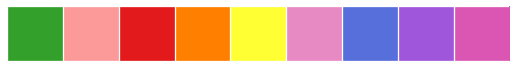

In [43]:
selfdesignpalette = np.concatenate((np.array(palettes[0][3:]),np.array(sns.color_palette(palettes[2]))[np.array([4,5])]
                                   ,np.array(sns.color_palette(palettes[3]))[3].reshape(1,-1),np.array(sns.color_palette(palettes[5]))[np.array([-3,-2,-1])]
                                  ))
sns.palplot(selfdesignpalette)

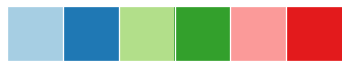

In [44]:
sns.palplot(palettes[0])

In [45]:
palettes_ = {}
palettes_[0] =  selfdesignpalette
for i in range(len(palettes)):
    palettes_[i+1] = palettes[i]
palettes = palettes_

### plot fig1

In [7]:
display(datatable1.head(3))
display(datatable2.head(3))

,BCLC,S domain-HCC,S domain-Health,S domain-HBV
0,B,8.60,7.20,1.09
1,C,4.85,5.39,2.14
2,B,9.24,5.41,-5.32


,HD,HCC
0,5.85,9.28
1,6.56,8.73
2,7.38,7.48


for fig 1, create table: <br>
sample expression
plasma_HCC plasma_Normal plasma_HBV+Normal
exosome_HCC,exosome_Normal

In [8]:
plasma_HCC = np.array(datatable1['S domain-HCC'])
plasma_HCC = plasma_HCC[~np.isnan(plasma_HCC)]
plasma_Normal = np.array(datatable1['S domain-Health'])
plasma_Normal = plasma_Normal[~np.isnan(plasma_Normal)]
plasma_HBV_Normal = np.concatenate((np.array(datatable1['S domain-Health']),np.array(datatable1['S domain-HBV'])))
plasma_HBV_Normal = plasma_HBV_Normal[~np.isnan(plasma_HBV_Normal)]
exosome_HCC= np.array(datatable2['HCC'])
exosome_HCC= exosome_HCC[~np.isnan(exosome_HCC)]
exosome_Normal = np.array(datatable2['HD'])
exosome_Normal= exosome_Normal[~np.isnan(exosome_Normal)]

In [9]:
plasma_HCCtab = pd.DataFrame(np.concatenate((np.repeat('plasma_HCC',plasma_HCC.shape[0]).reshape(-1,1),
                                        plasma_HCC.reshape(-1,1)),axis=1))
plasma_Normaltab = pd.DataFrame(np.concatenate((np.repeat('plasma_Normal',plasma_Normal.shape[0]).reshape(-1,1),
                                        plasma_Normal.reshape(-1,1)),axis=1))
plasma_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('plasma_HBV_Normal',plasma_HBV_Normal.shape[0]).reshape(-1,1),
                                        plasma_HBV_Normal.reshape(-1,1)),axis=1))
exosome_HCCtab = pd.DataFrame(np.concatenate((np.repeat('exosome_HCC',exosome_HCC.shape[0]).reshape(-1,1),
                                        exosome_HCC.reshape(-1,1)),axis=1))
exosome_Normaltab = pd.DataFrame(np.concatenate((np.repeat('exosome_Normal',exosome_Normal.shape[0]).reshape(-1,1),
                                        exosome_Normal.reshape(-1,1)),axis=1))

wholetab1 = pd.concat((plasma_HCCtab,plasma_Normaltab,plasma_HBV_Normaltab,exosome_HCCtab,exosome_Normaltab),axis=0)
wholetab1.columns = ['sample','expression']
wholetab1['expression'] = pd.to_numeric(wholetab1['expression'])
wholetab1.head()

,sample,expression
0,plasma_HCC,8.60
1,plasma_HCC,4.85
2,plasma_HCC,9.24
3,plasma_HCC,2.26
4,plasma_HCC,7.76


#### wilcoxon test and fold change

In [10]:
np.average(plasma_HCC)-np.average(plasma_HBV_Normal)

4.240339367612373

In [11]:
def calculate_fc(data1,data2):
    return 2**(np.average(data1)-np.average(data2))

In [12]:
import scipy.stats as ss
print ('cf hcc vs health p value: '+ str(ss.ranksums(plasma_HCC,plasma_Normal)[1]))
print ('cf hcc vs health_hbv p value: '+ str(ss.ranksums(plasma_HCC,plasma_HBV_Normal)[1]))
print ('exo hcc vs health p value: '+ str(ss.ranksums(exosome_HCC,exosome_Normal)[1]))

fc1 = calculate_fc(plasma_HCC,plasma_Normal)
fc2 = calculate_fc(plasma_HCC,plasma_HBV_Normal)
fc3 = calculate_fc(exosome_HCC,exosome_Normal)
print ('cf hcc vs health fold change: '+ str(fc1))
print ('cf hcc vs health_hbv fold change: '+ str(fc2))
print ('exo hcc vs health fold change: '+ str(fc3))

cf hcc vs health p value: 0.0002652980819686067
cf hcc vs health_hbv p value: 1.329252212585876e-09
exo hcc vs health p value: 0.05878172135535886
cf hcc vs health fold change: 10.290724855895078
cf hcc vs health_hbv fold change: 18.900328016358124
exo hcc vs health fold change: 5.739798138426813


##### boxplot fig1
**分为两部分，分别是cell free的三个box和exosome的两个box **<br>
cell free的三个box分别为hcc，normal以及normal和HBV<br>
exosome的两个box分别为hcc，normal

In [13]:
def box_plot_1(styind,contextind,width,height,showdot,showbox,dotsize,fontsize,
               ylim,boxwidth,box_violin,compareheight1,compareheight2,compareheight3,palettesind,saturation):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])


    fig, ax = plt.subplots(figsize=(width,height))
    if showbox =='yes':
        if box_violin=='violin':
            sns.violinplot(ax=ax,x="sample", y="expression", data=wholetab1, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
        elif box_violin=='box':
            sns.boxplot(ax=ax,x="sample", y="expression", data=wholetab1, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
    if showdot =='yes':
        sns.swarmplot(x="sample", y="expression", data=wholetab1, size=dotsize, edgecolor="black", linewidth=.9)
    ax.set_ylim(ylim)
    # statistical annotation
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = wholetab1['expression'].max() + compareheight1, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc1)+ '\n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 0, 2
    y, h, col = wholetab1['expression'].max() + compareheight2, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc2)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 3, 4 
    y, h, col = wholetab1['expression'].max() + compareheight3, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc3)+ ' \n ns', ha='center', va='bottom', color=col,size=fontsize)
interact(box_plot_1,styind=FloatSlider(min=0,max=3,step=1,value=2),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=8,max=20,step=1,value=12),
                 height= FloatSlider(min=4,max=10,step=1,value=6),
         boxwidth= FloatSlider(min=0.05,max=1,step=0.05,value=0.6),
         dotsize= FloatSlider(min=1,max=8,step=1,value=5),
         fontsize= FloatSlider(min=8,max=30,step=2,value=12),
         ylim=FloatRangeSlider(value=[-15, 28],min=-20,max=35.0,step=1),
            showdot=RadioButtons(options=['yes','no']),
         showbox=RadioButtons(options=['yes','no']),
        box_violin = Dropdown(options=['box','violin'],value='violin'),
         compareheight1=FloatSlider(min=3,max=10,step=1,value=4),
         compareheight2=FloatSlider(min=3,max=10,step=1,value=8),
         compareheight3=FloatSlider(min=3,max=10,step=1,value=8),
        palettesind=IntSlider(min=0,max=len(palettes)-1,step=1,value=4),
        saturation=FloatSlider(min=0,max=1,step=0.1,value=0.8))

interactive(children=(FloatSlider(value=2.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=12.0, description=u'width', max=20.0, min=8.0, step=1.0), FloatSlider(value=6.0, description=u'height', max=10.0, min=4.0, step=1.0), RadioButtons(description=u'showdot', options=('yes', 'no'), value='yes'), RadioButtons(description=u'showbox', options=('yes', 'no'), value='yes'), FloatSlider(value=5.0, description=u'dotsize', max=8.0, min=1.0, step=1.0), FloatSlider(value=12.0, description=u'fontsize', max=30.0, min=8.0, step=2.0), FloatRangeSlider(value=(-15.0, 28.0), description=u'ylim', max=35.0, min=-20.0, step=1.0), FloatSlider(value=0.6, description=u'boxwidth', max=1.0, min=0.05, step=0.05), Dropdown(description=u'box_violin', index=1, options=('box', 'violin'), value='violin'), FloatSlider(value=4.0, description=u'compareheight1', max=10.0, min=3.0, step=1.0), FloatSlider(value=8.0, description=u'compareheight2', max=10.0, min=3.0, step=1.0), FloatSlider(value=8.0, description=u'compareheight3', max=10.0, min=3.0, step=1.0), IntSlider(value=4, description=u'palettesind', max=12), FloatSlider(value=0.8, description=u'saturation', max=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.box_plot_1>

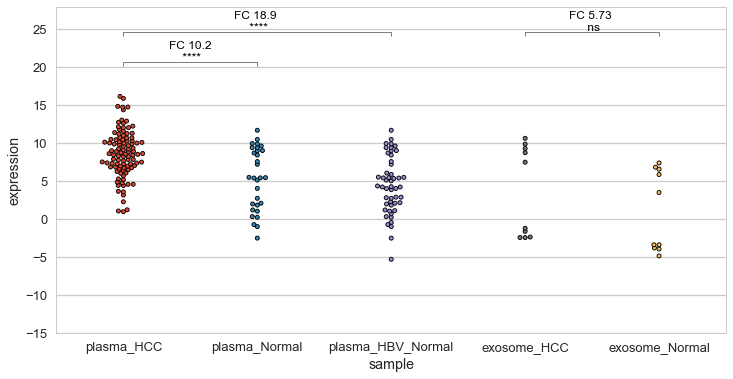

In [14]:
box_plot_1(2,1,12,6,'yes','no',4,12,[-15,28],0.25,'violin',4,8,8,4,1)

##### rocplot fig1
**分别计算cell free和exosome中hcc对normal的roc**

In [15]:
def find_metrics_best(label,expressionlevel):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    
    Sensitivity = tp/(tp+fn) 
    Specificity = tn/(tn+fp) 
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    #print ("AUC:" +str(auc))
    
    thres = int(label.shape[0]/10.) if int(label.shape[0]/10.)>0 else 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres],np.argsort(-mcc_mean)[:thres],np.argsort(-F1_score)[:thres])),return_counts=True)
    #print (Sensitivity[uni[np.where(counts ==np.max(counts))][0]])
    #print (Specificity[uni[np.where(counts ==np.max(counts))][0]])
    #print (F1_score)
    #print (np.argsort(-F1_score))
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][0]],Specificity[uni[np.where(counts ==np.max(counts))][0]]

In [16]:
aucspesenarr = np.concatenate(((np.array(find_metrics_best(np.concatenate((np.ones([exosome_HCC.shape[0]]),np.zeros([exosome_Normal.shape[0]]))),np.concatenate((exosome_HCC,exosome_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_HBV_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_HBV_Normal)))).reshape(1,-1)
               )))
auc,spe,sen= {},{},{}
for i in range(3):
    auc[i],spe[i],sen[i] = aucspesenarr[i][0],aucspesenarr[i][1],aucspesenarr[i][2]
label1 = ['exosome','plasma -HBV','plasma +HBV']
label2 = ['AUC: ' + str('%0.4s'%auc[i]) +' ['+str('%0.4s'%spe[i])+' '+str('%0.4s'%sen[i])+']' for i in range(3)]
#label1[i] +'\n'+label2[i]

def rocplot1(styind,contextind,width,height,linewid,color,linewid2,color2,transparency,fontsize,showmetrics):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    if len(color) !=3:
        color = ['r','g','b']
    label1 = ['exosome','plasma -HBV','plasma +HBV']
    label2 = ['AUC: ' + str('%0.4s'%auc[i]) +' ['+str('%0.4s'%spe[i])+' '+str('%0.4s'%sen[i])+']' for i in range(3)]
    if showmetrics =='yes':
        labels = [label1[i] +'\n'+label2[i] for i in range(3)]
    else:
        labels = [label1[i] for i in range(3)]
    a,b,_ = roc_curve(np.concatenate((np.ones([exosome_HCC.shape[0]]),np.zeros([exosome_Normal.shape[0]]))),np.concatenate((exosome_HCC,exosome_Normal)),drop_intermediate=False)   
    ax.plot(a,b,linewidth=linewid,color=color[0],label=labels[0])
    a,b,_ = roc_curve(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[1],label=labels[1])
    a,b,_ = roc_curve(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_HBV_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[2],label=labels[2])
    ax.legend(prop={'size': fontsize})
    #ax.plot(b,a,linewidth=linewid,color=color,linestyle='dashed') #solid’ | ‘dashed’, ‘dashdot’, ‘dotted
    ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2,linestyle='--')
interact(rocplot1,styind=FloatSlider(min=0,max=2,step=1,value=1),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=6,max=16,step=1,value=8),
                 height= FloatSlider(min=6,max=16,step=1,value=8),
        linewid= FloatSlider(min=1,max=4,step=0.3,value=1.5),
        color=SelectMultiple(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'],value=('b', 'g', 'r')),
        linewid2= FloatSlider(min=1,max=4,step=0.3,value=1.5),
         fontsize= FloatSlider(min=6,max=20,step=1,value=10),
        transparency=FloatSlider(min=0,max=1,step=0.05,value=0.5),
        color2=Dropdown(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']),
        showmetrics=RadioButtons(options=['yes','no']))

interactive(children=(FloatSlider(value=1.0, description=u'styind', max=2.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=8.0, description=u'width', max=16.0, min=6.0, step=1.0), FloatSlider(value=8.0, description=u'height', max=16.0, min=6.0, step=1.0), FloatSlider(value=1.5, description=u'linewid', max=4.0, min=1.0, step=0.3), SelectMultiple(description=u'color', index=(0, 1, 2), options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value=('b', 'g', 'r')), FloatSlider(value=1.5, description=u'linewid2', max=4.0, min=1.0, step=0.3), Dropdown(description=u'color2', options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value='b'), FloatSlider(value=0.5, description=u'transparency', max=1.0, step=0.05), FloatSlider(value=10.0, description=u'fontsize', max=20.0, min=6.0, step=1.0), RadioButtons(description=u'showmetrics', options=('yes', 'no'), value='yes'), Output()), _dom_classes=('widget-interact',))

<function __main__.rocplot1>

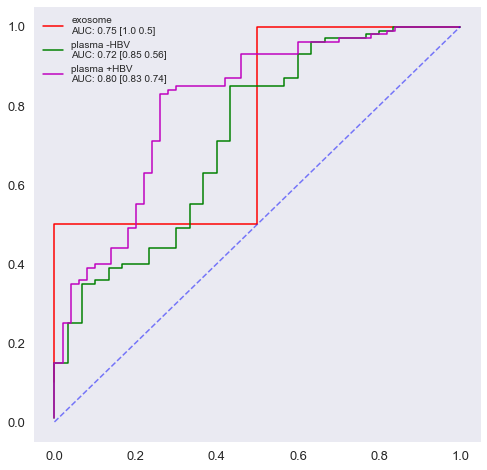

In [17]:
rocplot1(1,1,8,8,1.5,['r','g','m'],1.5,'b',0.5,10,'yes')

##### report best specificity &sensitivity
 $$TPR  =\frac{TP}{ TP + FN}$$  

 $$FPR =\frac{FP}{ FP + TN} $$

$$Acc=\frac{TP+TN}{TP+TN+FP+FN}=\frac{TP+TN}{P+N}$$

$$Recall/Sensitivity=\frac{TP}{TP+FN}= \frac{TP}{P}$$ <br>
$$Precision/PPV=\frac{TP}{TP+FP}$$<br>
$$Specificity=\frac{TN}{TN+FP}$$<br>
$$F1=\frac{2TP}{2TP+FN+FP}=\frac{2 \cdot Precision \cdot Recall}{Precision+Recall}$$
$$arith\_mean = \frac{Specificity+Sensitivity}{2}$$<br>
$$geo\_mean = \sqrt {Specificity \dot Sensitivity}$$<br>
$$harmo\_mean = \frac{1}{\frac{1}{Specificity}+\frac{1}{Sensitivity}}$$<br>
$$mcc\_mean = \frac{TP \dot TN-FP \dot FN}{(TP+FP)(TN+FP)(TP+FN)(TN+FN)} $$<br>
$$distoleftup = \sqrt{FPR^2+(1-TPR)^2 }$$<br>

##### best sensitivity and specificity:
各个指标的一致较优集合中的交集作为最终选择标准

AUC:0.7200000000000001


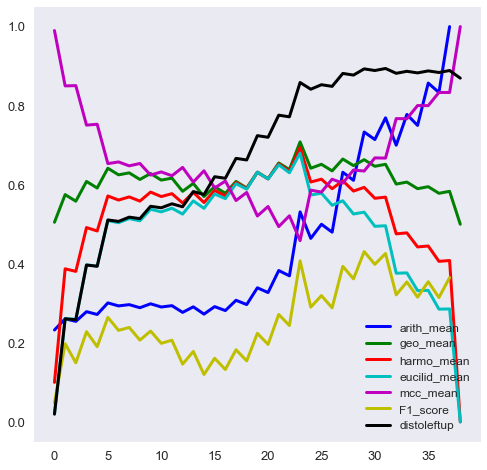

In [18]:
def report_metrics_best(expressionlevel,label):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    
    Sensitivity = tp/(tp+fn) 
    Specificity = tn/(tn+fp) 
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    print ("AUC:" +str(auc))
    return auc,tp,fp,tn,fn,acc,Sensitivity,Specificity,PPV,NPV,arith_mean,geo_mean,harmo_mean,eucilid_mean,mcc_mean,F1_score,distoleftup
def metricsplot(styind,contextind,width,height,linewid,metrics,fontsize):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    allmetrics = np.array(['tp','fp','tn','fn','acc','Sensitivity','Specificity','PPV','NPV',
                           'arith_mean','geo_mean','harmo_mean','eucilid_mean','mcc_mean','F1_score','distoleftup'])
    metricss = report_metrics_best( np.concatenate((plasma_HCC,plasma_Normal)),
                                        np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_Normal.shape[0]]))))[:]
    for i in range(len(metrics)):
        indtmp = np.where(allmetrics==metrics[i])[0]
        if indtmp.shape[0]:
            ax.plot(metricss[indtmp[0]],linewidth=linewid,color=colors[i],label=allmetrics[indtmp[0]] )
    ax.legend(prop={'size': fontsize})#[allmetrics[indtmp[0]]],prop={'size': fontsize})
    #ax.plot(arith_mean,linewidth=linewid,color=color)
    #ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2)
metricsplot(1,1,8,8,3,['arith_mean','geo_mean','harmo_mean','eucilid_mean',
                                        'mcc_mean','F1_score','distoleftup'],12)

##### 三条曲线的AUC及最佳specificity与sensitivity组合

In [19]:
pd.DataFrame(np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([exosome_HCC.shape[0]]),np.zeros([exosome_Normal.shape[0]]))),np.concatenate((exosome_HCC,exosome_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([plasma_HCC.shape[0]]),np.zeros([plasma_HBV_Normal.shape[0]]))),np.concatenate((plasma_HCC,plasma_HBV_Normal)))).reshape(1,-1)
               )),columns=['AUC','Specificity','Sensitivity'],
             index=['exosome','plasma -HBV','plasma +HBV'])


,AUC,Specificity,Sensitivity
exosome,0.7500,1.00,0.500000
plasma -HBV,0.7200,0.85,0.566667
plasma +HBV,0.8042,0.83,0.740000


In [16]:
def metricsplot(styind,contextind,width,height,linewid,metrics,fontsize):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    allmetrics = np.array(['tp','fp','tn','fn','acc','Sensitivity','Specificity','PPV','NPV',
                           'arith_mean','geo_mean','harmo_mean','eucilid_mean','mcc_mean','F1_score','distoleftup'])
    for i in range(len(metrics)):
        indtmp = np.where(allmetrics==metrics[i])[0]
        if indtmp.shape[0]:
            ax.plot(report_metrics_best(np.concatenate((exosome_HCC,exosome_Normal)),np.concatenate((np.ones([exosome_HCC.shape[0]]),np.zeros([exosome_Normal.shape[0]]))))[1:][indtmp[0]],linewidth=linewid,color=colors[i],
                    label=allmetrics[indtmp[0]] )
    ax.legend(prop={'size': fontsize})#[allmetrics[indtmp[0]]],prop={'size': fontsize})
    #ax.plot(arith_mean,linewidth=linewid,color=color)
    #ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2)
interact(metricsplot,styind=FloatSlider(min=0,max=2,step=1,value=1),
               contextind=FloatSlider(min=0,max=3,step=1),
                width =FloatSlider(min=6,max=16,step=1,value=9),
                 height= FloatSlider(min=6,max=16,step=1,value=9),
        linewid= FloatSlider(min=1,max=4,step=0.3,value=1.5),
         fontsize= FloatSlider(min=6,max=20,step=1,value=10),
        metrics=SelectMultiple(options=['tp','fp','tn','fn','acc','Sensitivity','Specificity','PPV','NPV','arith_mean','geo_mean','harmo_mean','eucilid_mean',
                                        'mcc_mean','F1_score','distoleftup'],value=('arith_mean',)))

interactive(children=(FloatSlider(value=1.0, description=u'styind', max=2.0, step=1.0), FloatSlider(value=0.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=9.0, description=u'width', max=16.0, min=6.0, step=1.0), FloatSlider(value=9.0, description=u'height', max=16.0, min=6.0, step=1.0), FloatSlider(value=1.5, description=u'linewid', max=4.0, min=1.0, step=0.3), SelectMultiple(description=u'metrics', index=(9,), options=('tp', 'fp', 'tn', 'fn', 'acc', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'arith_mean', 'geo_mean', 'harmo_mean', 'eucilid_mean', 'mcc_mean', 'F1_score', 'distoleftup'), value=('arith_mean',)), FloatSlider(value=10.0, description=u'fontsize', max=20.0, min=6.0, step=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.metricsplot>

### plot fig2

In [20]:
datatable1.head(2)

,BCLC,S domain-HCC,S domain-Health,S domain-HBV
0,B,8.60,7.20,1.09
1,C,4.85,5.39,2.14


In [21]:
def load_data(table):
    datatable = table
    return np.array(datatable.loc[datatable['BCLC'] =="A",["S domain-HCC"]]).ravel().astype('float'),np.array(datatable.loc[datatable['BCLC'] =="B",["S domain-HCC"]]).ravel().astype('float'),np.array(datatable.loc[datatable['BCLC'] =="C",["S domain-HCC"]]).ravel().astype('float'),np.array(datatable['S domain-Health']).ravel().astype('float')

stageA,stageB,stageC,health = load_data(datatable1)
health= datatable1['S domain-Health']
health = health[~np.isnan(health)]
hcc = np.concatenate((stageA,stageB,stageC))

In [22]:
stageAtab = pd.DataFrame(np.concatenate((np.repeat('hcc',stageA.shape[0]).reshape(-1,1),
                                         np.repeat('stageA',stageA.shape[0]).reshape(-1,1),stageA.reshape(-1,1)),axis=1))
stageBtab = pd.DataFrame(np.concatenate((np.repeat('hcc',stageB.shape[0]).reshape(-1,1),
                                         np.repeat('stageB',stageB.shape[0]).reshape(-1,1),stageB.reshape(-1,1)),axis=1))
stageCtab = pd.DataFrame(np.concatenate((np.repeat('hcc',stageC.shape[0]).reshape(-1,1),
                                         np.repeat('stageC',stageC.shape[0]).reshape(-1,1),stageC.reshape(-1,1)),axis=1))
healthtab = pd.DataFrame(np.concatenate((np.repeat('health',health.shape[0]*2).reshape(-1,2),health.reshape(-1,1)),axis=1))
wholetab = pd.concat((stageAtab,stageBtab,stageCtab,healthtab),axis=0)
wholetab.columns = ['sample','stage','expression']
wholetab.head()
wholetab['expression'] = pd.to_numeric(wholetab['expression'])
wholetab.head()

import scipy.stats as ss
values_per_group = [col for col_name, col in wholetab.groupby('sample')['expression']]
print ('hcc vs health p value: '+ str(ss.ranksums(*values_per_group)[1]))
print ('stageA vs health p value: '+ str(ss.ranksums(wholetab[wholetab['stage']=="stageA"]['expression'],wholetab[wholetab['stage']=="health"]['expression'])[1]))
print ('stageB vs health p value: '+ str(ss.ranksums(wholetab[wholetab['stage']=="stageB"]['expression'],wholetab[wholetab['stage']=="health"]['expression'])[1]))
print ('stageC vs health p value: '+ str(ss.ranksums(wholetab[wholetab['stage']=="stageB"]['expression'],wholetab[wholetab['stage']=="health"]['expression'])[1]))


fc1 = calculate_fc(hcc,health)
fc2 = calculate_fc(stageA,health)
fc3 = calculate_fc(stageB,health)
fc4 = calculate_fc(stageC,health)
print ('hcc vs health fold change: '+ str(fc1))
print ('stageA vs health fold change: '+ str(fc2))
print ('stageB vs health fold change: '+ str(fc3))
print ('stageC vs health fold change: '+ str(fc4))


hcc vs health p value: 0.00022107588259178435
stageA vs health p value: 0.00634116343477631
stageB vs health p value: 0.0004336778335061887
stageC vs health p value: 0.0004336778335061887
hcc vs health fold change: 10.99048148865632
stageA vs health fold change: 8.000297354246165
stageB vs health fold change: 16.51559545990606
stageC vs health fold change: 11.376894338182627


#####  boxplot fig2
cell free中三期对health

In [23]:
def box_plot_stage(styind,contextind,width,height,showdot,showbox,
                   dotsize,fontsize,ylim,compareheight1,compareheight2,compareheight3,boxwidth,box_violin,palettesind,saturation):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])


    fig, ax = plt.subplots(figsize=(width,height))
    if showbox =='yes':
        if box_violin=='violin':
            sns.violinplot(ax=ax,x="stage", y="expression", data=wholetab, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
        elif box_violin=='box':
            sns.boxplot(ax=ax,x="stage", y="expression", data=wholetab, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
    if showdot =='yes':
        sns.swarmplot(x="stage", y="expression", data=wholetab, size=dotsize, edgecolor="black", linewidth=.9)
    ax.set_ylim(ylim)
    # statistical annotation
    x1, x2 = 0, 3   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = wholetab['expression'].max() + compareheight1, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.1, y+h, 'FC ' +str('%0.4s'%fc1)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 1, 3 
    y, h, col = wholetab['expression'].max() + compareheight2, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.35, y+h, 'FC ' +str('%0.4s'%fc2)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 2, 3 
    y, h, col = wholetab['expression'].max() + compareheight3, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc3)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
interact(box_plot_stage,styind=FloatSlider(min=0,max=3,step=1,value=2),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=8,max=20,step=1,value=12),
                 height= FloatSlider(min=4,max=10,step=1,value=6),
         dotsize= FloatSlider(min=1,max=15,step=1,value=8),
         fontsize= FloatSlider(min=8,max=30,step=2,value=12),
         ylim=FloatRangeSlider(value=[-10, 25],min=-20,max=30.0,step=3),
            showdot=RadioButtons(options=['yes','no']),
          showbox=RadioButtons(options=['yes','no']),
        compareheight1=FloatSlider(min=1,max=10,step=1,value=1),
         compareheight2=FloatSlider(min=1,max=10,step=1,value=3),
         compareheight3=FloatSlider(min=1,max=10,step=1,value=5),
        boxwidth= FloatSlider(min=0.05,max=1,step=0.05,value=0.5),
        box_violin = Dropdown(options=['box','violin'],value='box'),
        palettesind=IntSlider(min=0,max=len(palettes)-1,step=1,value=4),
        saturation=FloatSlider(min=0,max=1,step=0.1,value=0.8))

interactive(children=(FloatSlider(value=2.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=12.0, description=u'width', max=20.0, min=8.0, step=1.0), FloatSlider(value=6.0, description=u'height', max=10.0, min=4.0, step=1.0), RadioButtons(description=u'showdot', options=('yes', 'no'), value='yes'), RadioButtons(description=u'showbox', options=('yes', 'no'), value='yes'), FloatSlider(value=8.0, description=u'dotsize', max=15.0, min=1.0, step=1.0), FloatSlider(value=12.0, description=u'fontsize', max=30.0, min=8.0, step=2.0), FloatRangeSlider(value=(-10.0, 25.0), description=u'ylim', max=30.0, min=-20.0, step=3.0), FloatSlider(value=1.0, description=u'compareheight1', max=10.0, min=1.0, step=1.0), FloatSlider(value=3.0, description=u'compareheight2', max=10.0, min=1.0, step=1.0), FloatSlider(value=5.0, description=u'compareheight3', max=10.0, min=1.0, step=1.0), FloatSlider(value=0.5, description=u'boxwidth', max=1.0, min=0.05, step=0.05), Dropdown(description=u'box_violin', options=('box', 'violin'), value='box'), IntSlider(value=4, description=u'palettesind', max=12), FloatSlider(value=0.8, description=u'saturation', max=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.box_plot_stage>

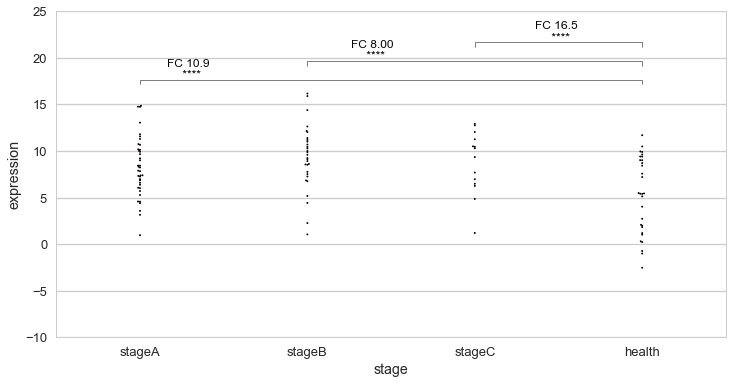

In [24]:
box_plot_stage(2,1,12,6,'yes','no',1,12,[-10,25],1,3,5,0.2,'box',4,1)

#####  rocplot fig2

In [25]:
aucspesenarr = np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([stageA.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageA,health)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([stageB.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageB,health)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([stageC.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageC,health)))).reshape(1,-1),
                             np.array(find_metrics_best(np.concatenate((np.ones([hcc.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((hcc,health)))).reshape(1,-1)
               ))
auc,spe,sen= {},{},{}
for i in range(4):
    auc[i],spe[i],sen[i] = aucspesenarr[i][0],aucspesenarr[i][1],aucspesenarr[i][2]
label1 = ['Stage A','Stage B','Stage C','HCC']
label2 = ['AUC: ' + str('%0.4s'%auc[i]) +' ['+str('%0.4s'%spe[i])+' '+str('%0.4s'%sen[i])+']' for i in range(4)]

def rocplot_stage(styind,contextind,width,height,linewid,color,linewid2,color2,transparency,fontsize,showmetrics):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    if len(color) !=4:
        color = ['r','g','b','m']
    if showmetrics =='yes':
        labels = [label1[i] +'\n'+label2[i] for i in range(4)]
    else:
        labels = [label1[i] for i in range(4)]
    a,b,_ = roc_curve(np.concatenate((np.ones([stageA.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageA,health)))   
    ax.plot(a,b,linewidth=linewid,color=color[0],label=labels[0])
    a,b,_ = roc_curve(np.concatenate((np.ones([stageB.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageB,health)))   
    ax.plot(a,b,linewidth=linewid,color=color[1],label=labels[1])
    a,b,_ = roc_curve(np.concatenate((np.ones([stageC.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageC,health)))   
    ax.plot(a,b,linewidth=linewid,color=color[2],label=labels[2])
    a,b,_ = roc_curve(np.concatenate((np.ones([hcc.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((hcc,health)))   
    ax.plot(a,b,linewidth=linewid,color=color[3],label=labels[3])
    ax.legend(prop={'size': fontsize})
    #ax.plot(b,a,linewidth=linewid,color=color,linestyle='dashed') #solid’ | ‘dashed’, ‘dashdot’, ‘dotted
    ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2,linestyle='--')
interact(rocplot_stage,styind=FloatSlider(min=0,max=3,step=1,value=2),
               contextind=FloatSlider(min=0,max=3,step=1),
                width =FloatSlider(min=6,max=16,step=1,value=8),
                 height= FloatSlider(min=6,max=16,step=1,value=8),
        linewid= FloatSlider(min=1,max=4,step=0.3,value=1.5),
        color=SelectMultiple(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'],value=('b', 'g', 'r','m')),
        linewid2= FloatSlider(min=1,max=4,step=0.3,value=1.5),
         fontsize= FloatSlider(min=6,max=20,step=1,value=10),
        transparency=FloatSlider(min=0,max=1,step=0.05,value=0.5),
        color2=Dropdown(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']),
        showmetrics=RadioButtons(options=['yes','no']))

interactive(children=(FloatSlider(value=2.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=0.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=8.0, description=u'width', max=16.0, min=6.0, step=1.0), FloatSlider(value=8.0, description=u'height', max=16.0, min=6.0, step=1.0), FloatSlider(value=1.5, description=u'linewid', max=4.0, min=1.0, step=0.3), SelectMultiple(description=u'color', index=(0, 1, 2, 4), options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value=('b', 'g', 'r', 'm')), FloatSlider(value=1.5, description=u'linewid2', max=4.0, min=1.0, step=0.3), Dropdown(description=u'color2', options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value='b'), FloatSlider(value=0.5, description=u'transparency', max=1.0, step=0.05), FloatSlider(value=10.0, description=u'fontsize', max=20.0, min=6.0, step=1.0), RadioButtons(description=u'showmetrics', options=('yes', 'no'), value='yes'), Output()), _dom_classes=('widget-interact',))

<function __main__.rocplot_stage>

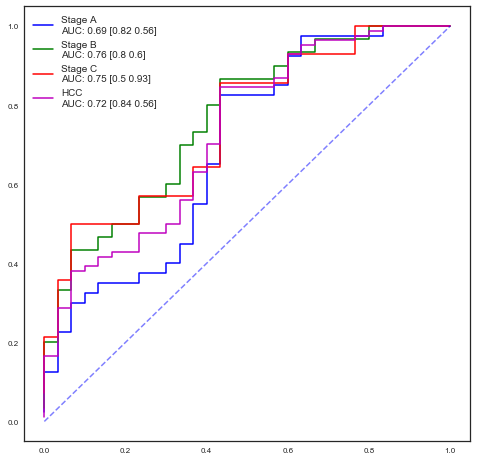

In [26]:
rocplot_stage(0,0,8,8,1.5,['b','g','r','m'],1.5,'b',0.5,10,'yes')

In [27]:
pd.DataFrame(np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([stageA.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageA,health)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([stageB.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageB,health)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([stageC.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((stageC,health)))).reshape(1,-1),
                             np.array(find_metrics_best(np.concatenate((np.ones([hcc.shape[0]]),np.zeros([health.shape[0]]))),np.concatenate((hcc,health)))).reshape(1,-1)
               )),columns=['AUC','Specificity','Sensitivity'],
             index=['stageA','stageB','stageC','HCC'])


,AUC,Specificity,Sensitivity
stageA,0.691667,0.825000,0.566667
stageB,0.764444,0.800000,0.600000
stageC,0.752381,0.500000,0.933333
HCC,0.727778,0.845238,0.566667


### plot fig3

In [28]:
datatable3.head(2)

,S-Health,S-HBV,S-HCC,L-Health,L-HBV,L-HCC
0,10.95,9.62,12.23,5.73,6.41,7.18
1,9.26,11.67,12.38,3.20,3.73,7.52


In [29]:
S_HCC = np.array(datatable3['S-HCC'])
S_HCC = S_HCC[~np.isnan(S_HCC)]
S_Normal = np.array(datatable3['S-Health'])
S_Normal = S_Normal[~np.isnan(S_Normal)]
S_HBV_Normal = np.concatenate((np.array(datatable3['S-Health']),np.array(datatable3['S-HBV'])))
S_HBV_Normal = S_HBV_Normal[~np.isnan(S_HBV_Normal)]

L_HCC = np.array(datatable3['L-HCC'])
L_HCC = L_HCC[~np.isnan(L_HCC)]
L_Normal = np.array(datatable3['L-Health'])
L_Normal = L_Normal[~np.isnan(L_Normal)]
L_HBV_Normal = np.concatenate((np.array(datatable3['L-Health']),np.array(datatable3['L-HBV'])))
L_HBV_Normal = L_HBV_Normal[~np.isnan(L_HBV_Normal)]

S_HCCtab = pd.DataFrame(np.concatenate((np.repeat('S_HCC',S_HCC.shape[0]).reshape(-1,1),
                                        S_HCC.reshape(-1,1)),axis=1))
S_Normaltab = pd.DataFrame(np.concatenate((np.repeat('S_Normal',S_Normal.shape[0]).reshape(-1,1),
                                        S_Normal.reshape(-1,1)),axis=1))
S_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('S_HBV_Normal',S_HBV_Normal.shape[0]).reshape(-1,1),
                                        S_HBV_Normal.reshape(-1,1)),axis=1))

L_HCCtab = pd.DataFrame(np.concatenate((np.repeat('L_HCC',L_HCC.shape[0]).reshape(-1,1),
                                        L_HCC.reshape(-1,1)),axis=1))
L_Normaltab = pd.DataFrame(np.concatenate((np.repeat('L_Normal',L_Normal.shape[0]).reshape(-1,1),
                                        L_Normal.reshape(-1,1)),axis=1))
L_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('L_HBV_Normal',L_HBV_Normal.shape[0]).reshape(-1,1),
                                        L_HBV_Normal.reshape(-1,1)),axis=1))



wholetab2 = pd.concat((S_HCCtab,S_Normaltab,S_HBV_Normaltab,L_HCCtab,L_Normaltab,L_HBV_Normaltab),axis=0)
wholetab2.columns = ['sample','expression']
wholetab2['expression'] = pd.to_numeric(wholetab2['expression'])
wholetab2.head()


import scipy.stats as ss
print ('S hcc vs health p value: '+ str(ss.ranksums(S_HCC,S_Normal)[1]))
print ('S hcc vs health_hbv p value: '+ str(ss.ranksums(S_HCC,S_HBV_Normal)[1]))
print ('L hcc vs health p value: '+ str(ss.ranksums(L_HCC,L_Normal)[1]))
print ('L hcc vs health_hbv p value: '+ str(ss.ranksums(L_HCC,L_HBV_Normal)[1]))

fc1 = calculate_fc(S_HCC,S_Normal)
fc2 = calculate_fc(S_HCC,S_HBV_Normal)
fc3 = calculate_fc(L_HCC,L_Normal)
fc4 = calculate_fc(L_HCC,L_HBV_Normal)
print ('S hcc vs health fold change: '+ str(fc1))
print ('S hcc vs health_hbv fold change: '+ str(fc2))
print ('L hcc vs health fold change: '+ str(fc3))
print ('L hcc vs health_hbv fold change: '+ str(fc4))



S hcc vs health p value: 4.762608871459029e-05
S hcc vs health_hbv p value: 1.0474024611826171e-07
L hcc vs health p value: 0.00026816403903172196
L hcc vs health_hbv p value: 7.750174354805054e-07
S hcc vs health fold change: 2.0852205745985843
S hcc vs health_hbv fold change: 2.2771037098732063
L hcc vs health fold change: 2.2816328631265894
L hcc vs health_hbv fold change: 3.4933228946180916


#####  boxplot fig3
S domain 和 full length 中 HCC对normal以及HCC对(normal+HBV)

In [30]:
def box_plot_2(styind,contextind,width,height,showdot,showbox,dotsize,fontsize,
               ylim,boxwidth,box_violin,compareheight1,compareheight2,compareheight3,compareheight4,palettesind,saturation):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])


    fig, ax = plt.subplots(figsize=(width,height))
    if showbox =='yes':
        if box_violin=='violin':
            sns.violinplot(ax=ax,x="sample", y="expression", data=wholetab2, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
        elif box_violin=='box':
            sns.boxplot(ax=ax,x="sample", y="expression", data=wholetab2, palette=palettes[palettesind],width=boxwidth,saturation=saturation)

    if showdot =='yes':
        sns.swarmplot(x="sample", y="expression", data=wholetab2, size=dotsize, edgecolor="black", linewidth=.9)
    ax.set_ylim(ylim)
    # statistical annotation
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = wholetab2['expression'].max() + compareheight1, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc1)+ '\n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 0, 2
    y, h, col = wholetab2['expression'].max() + compareheight2, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc2)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 3, 4 
    y, h, col = wholetab2['expression'].max() + compareheight3, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc3)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 3, 5
    y, h, col = wholetab2['expression'].max() + compareheight4, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc4)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
interact(box_plot_2,styind=FloatSlider(min=0,max=3,step=1,value=2),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=8,max=20,step=1,value=12),
                 height= FloatSlider(min=4,max=10,step=1,value=6),
         boxwidth= FloatSlider(min=0.05,max=1,step=0.05,value=0.6),
         dotsize= FloatSlider(min=1,max=8,step=1,value=5),
         fontsize= FloatSlider(min=8,max=30,step=2,value=12),
         ylim=FloatRangeSlider(value=[-10, 25],min=-20,max=30.0,step=3),
            showdot=RadioButtons(options=['yes','no']),
         showbox=RadioButtons(options=['yes','no']),
        box_violin = Dropdown(options=['box','violin'],value='violin'),
         compareheight1=FloatSlider(min=3,max=10,step=1,value=3),
         compareheight2=FloatSlider(min=3,max=10,step=1,value=6),
         compareheight3=FloatSlider(min=3,max=10,step=1,value=3),
        compareheight4=FloatSlider(min=3,max=10,step=1,value=6),
        palettesind=IntSlider(min=0,max=len(palettes)-1,step=1,value=4),
        saturation=FloatSlider(min=0,max=1,step=0.1,value=0.8))


interactive(children=(FloatSlider(value=2.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=12.0, description=u'width', max=20.0, min=8.0, step=1.0), FloatSlider(value=6.0, description=u'height', max=10.0, min=4.0, step=1.0), RadioButtons(description=u'showdot', options=('yes', 'no'), value='yes'), RadioButtons(description=u'showbox', options=('yes', 'no'), value='yes'), FloatSlider(value=5.0, description=u'dotsize', max=8.0, min=1.0, step=1.0), FloatSlider(value=12.0, description=u'fontsize', max=30.0, min=8.0, step=2.0), FloatRangeSlider(value=(-10.0, 25.0), description=u'ylim', max=30.0, min=-20.0, step=3.0), FloatSlider(value=0.6, description=u'boxwidth', max=1.0, min=0.05, step=0.05), Dropdown(description=u'box_violin', index=1, options=('box', 'violin'), value='violin'), FloatSlider(value=3.0, description=u'compareheight1', max=10.0, min=3.0, step=1.0), FloatSlider(value=6.0, description=u'compareheight2', max=10.0, min=3.0, step=1.0), FloatSlider(value=3.0, description=u'compareheight3', max=10.0, min=3.0, step=1.0), FloatSlider(value=6.0, description=u'compareheight4', max=10.0, min=3.0, step=1.0), IntSlider(value=4, description=u'palettesind', max=12), FloatSlider(value=0.8, description=u'saturation', max=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.box_plot_2>

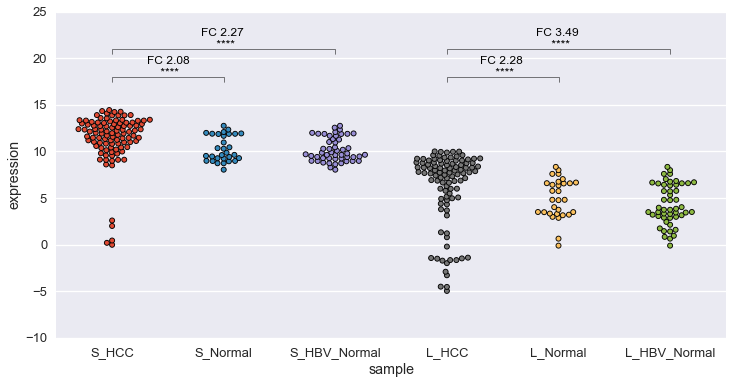

In [31]:
box_plot_2(3,1,12,6,'yes','no',5,12,[-10,25],0.6,'violin',3,6,3,6,4,0.8)

#####  rocplot fig3

In [32]:
aucspesenarr = np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))).reshape(1,-1),
               np.array(find_metrics_best(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_Normal.shape[0]]))),np.concatenate((L_HCC,L_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_HBV_Normal.shape[0]]))),np.concatenate((L_HCC,L_HBV_Normal)))).reshape(1,-1)
               ))
auc,spe,sen= {},{},{}
for i in range(4):
    auc[i],spe[i],sen[i] = aucspesenarr[i][0],aucspesenarr[i][1],aucspesenarr[i][2]
label1 = ['S -HBV','S +HBV','L -HBV','L +HBV']
label2 = ['AUC: ' + str('%0.4s'%auc[i]) +' ['+str('%0.4s'%spe[i])+' '+str('%0.4s'%sen[i])+']' for i in range(4)]


def rocplot2(styind,contextind,width,height,linewid,color,linewid2,color2,transparency,fontsize,showmetrics):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    if len(color) !=3:
        color = ['r','g','b','m']
    if showmetrics =='yes':
        labels = [label1[i] +'\n'+label2[i] for i in range(4)]
    else:
        labels = [label1[i] for i in range(4)]
    a,b,_ = roc_curve(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[0],label=labels[0])
    a,b,_ = roc_curve(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[1],label=labels[1])
    a,b,_ = roc_curve(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_Normal.shape[0]]))),np.concatenate((L_HCC,L_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[2],label=labels[2])
    a,b,_ = roc_curve(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_HBV_Normal.shape[0]]))),np.concatenate((L_HCC,L_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[3],label=labels[3])
    ax.legend(prop={'size': fontsize})
    #ax.plot(b,a,linewidth=linewid,color=color,linestyle='dashed') #solid’ | ‘dashed’, ‘dashdot’, ‘dotted
    ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2,linestyle='--')
interact(rocplot2,styind=FloatSlider(min=0,max=3,step=1,value=3),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=6,max=16,step=1,value=8),
                 height= FloatSlider(min=6,max=16,step=1,value=8),
        linewid= FloatSlider(min=1,max=4,step=0.3,value=1.5),
        color=SelectMultiple(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'],value=('b', 'g', 'r','m')),
        linewid2= FloatSlider(min=1,max=4,step=0.3,value=1.5),
         fontsize= FloatSlider(min=6,max=20,step=1,value=10),
        transparency=FloatSlider(min=0,max=1,step=0.05,value=0.5),
        color2=Dropdown(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']),
        showmetrics=RadioButtons(options=['yes','no']))

interactive(children=(FloatSlider(value=3.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=8.0, description=u'width', max=16.0, min=6.0, step=1.0), FloatSlider(value=8.0, description=u'height', max=16.0, min=6.0, step=1.0), FloatSlider(value=1.5, description=u'linewid', max=4.0, min=1.0, step=0.3), SelectMultiple(description=u'color', index=(0, 1, 2, 4), options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value=('b', 'g', 'r', 'm')), FloatSlider(value=1.5, description=u'linewid2', max=4.0, min=1.0, step=0.3), Dropdown(description=u'color2', options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value='b'), FloatSlider(value=0.5, description=u'transparency', max=1.0, step=0.05), FloatSlider(value=10.0, description=u'fontsize', max=20.0, min=6.0, step=1.0), RadioButtons(description=u'showmetrics', options=('yes', 'no'), value='yes'), Output()), _dom_classes=('widget-interact',))

<function __main__.rocplot2>

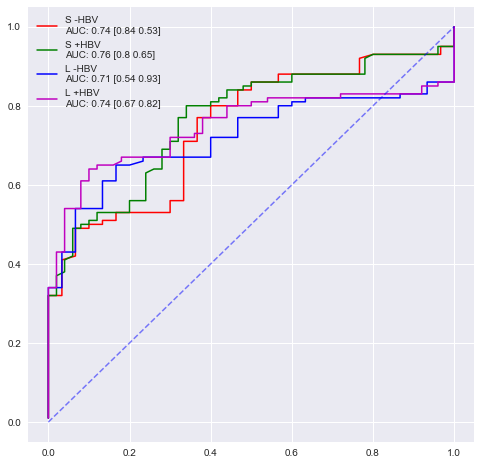

In [33]:
rocplot2(3,3,8,8,1.5,['b','g','r','m'],1.5,'b',0.5,10,'yes')

In [34]:
pd.DataFrame(np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))).reshape(1,-1),
               np.array(find_metrics_best(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_Normal.shape[0]]))),np.concatenate((L_HCC,L_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([L_HCC.shape[0]]),np.zeros([L_HBV_Normal.shape[0]]))),np.concatenate((L_HCC,L_HBV_Normal)))).reshape(1,-1)
               )),columns=['AUC','Specificity','Sensitivity'],
             index=['S -HBV','S +HBV','L -HBV','L +HBV'])


,AUC,Specificity,Sensitivity
S -HBV,0.745333,0.84,0.533333
S +HBV,0.766800,0.80,0.660000
L -HBV,0.719833,0.54,0.933333
L +HBV,0.747900,0.67,0.820000


### plot fig4

In [35]:
datatable4.head(5)

,Alu domain-Health,Alu domain-HBV,Alu domain-HCC,S domain-Health,S domain-HBV,S domain-HCC,MIR192-Health,MIR192-HBV,MIR192-HCC
0,3.75,2.55,8.74,7.20,1.09,8.60,2.74,2.97,0.87
1,1.41,5.37,3.79,5.39,2.14,4.85,-2.01,2.64,0.52
2,1.90,4.07,8.03,5.41,-5.32,9.24,-3.30,2.52,0.13
3,4.41,-5.49,0.59,9.01,4.00,2.26,2.31,1.79,-1.52
4,-4.12,1.32,6.80,5.44,5.51,7.76,-1.40,2.36,1.69


In [36]:
Alu_HCC = np.array(datatable4['Alu domain-HCC'])
Alu_HCC = Alu_HCC[~np.isnan(Alu_HCC)]
Alu_Normal = np.array(datatable4['Alu domain-Health'])
Alu_Normal = Alu_Normal[~np.isnan(Alu_Normal)]
Alu_HBV_Normal = np.concatenate((np.array(datatable4['Alu domain-Health']),np.array(datatable4['Alu domain-HBV'])))
Alu_HBV_Normal = Alu_HBV_Normal[~np.isnan(Alu_HBV_Normal)]

S_HCC = np.array(datatable4['S domain-HCC'])
S_HCC = S_HCC[~np.isnan(S_HCC)]
S_Normal = np.array(datatable4['S domain-Health'])
S_Normal = S_Normal[~np.isnan(S_Normal)]
S_HBV_Normal = np.concatenate((np.array(datatable4['S domain-Health']),np.array(datatable4['S domain-HBV'])))
S_HBV_Normal = S_HBV_Normal[~np.isnan(S_HBV_Normal)]

MIR_HCC = np.array(datatable4['MIR192-HCC'])
MIR_HCC = MIR_HCC[~np.isnan(MIR_HCC)]
MIR_Normal = np.array(datatable4['MIR192-Health'])
MIR_Normal = MIR_Normal[~np.isnan(MIR_Normal)]
MIR_HBV_Normal = np.concatenate((np.array(datatable4['MIR192-Health']),np.array(datatable4['MIR192-HBV'])))
MIR_HBV_Normal = MIR_HBV_Normal[~np.isnan(MIR_HBV_Normal)]

Alu_HCCtab = pd.DataFrame(np.concatenate((np.repeat('Alu_HCC',Alu_HCC.shape[0]).reshape(-1,1),
                                        Alu_HCC.reshape(-1,1)),axis=1))
Alu_Normaltab = pd.DataFrame(np.concatenate((np.repeat('Alu_Normal',Alu_Normal.shape[0]).reshape(-1,1),
                                        Alu_Normal.reshape(-1,1)),axis=1))
Alu_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('Alu_HBV_Normal',Alu_HBV_Normal.shape[0]).reshape(-1,1),
                                        Alu_HBV_Normal.reshape(-1,1)),axis=1))

S_HCCtab = pd.DataFrame(np.concatenate((np.repeat('S_HCC',S_HCC.shape[0]).reshape(-1,1),
                                        S_HCC.reshape(-1,1)),axis=1))
S_Normaltab = pd.DataFrame(np.concatenate((np.repeat('S_Normal',S_Normal.shape[0]).reshape(-1,1),
                                        S_Normal.reshape(-1,1)),axis=1))
S_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('S_HBV_Normal',S_HBV_Normal.shape[0]).reshape(-1,1),
                                        S_HBV_Normal.reshape(-1,1)),axis=1))

MIR_HCCtab = pd.DataFrame(np.concatenate((np.repeat('MIR_HCC',MIR_HCC.shape[0]).reshape(-1,1),
                                        MIR_HCC.reshape(-1,1)),axis=1))
MIR_Normaltab = pd.DataFrame(np.concatenate((np.repeat('MIR_Normal',MIR_Normal.shape[0]).reshape(-1,1),
                                        MIR_Normal.reshape(-1,1)),axis=1))
MIR_HBV_Normaltab = pd.DataFrame(np.concatenate((np.repeat('MIR_HBV_Normal',MIR_HBV_Normal.shape[0]).reshape(-1,1),
                                        MIR_HBV_Normal.reshape(-1,1)),axis=1))



wholetab3 = pd.concat((Alu_HCCtab,Alu_Normaltab,Alu_HBV_Normaltab,S_HCCtab,S_Normaltab,S_HBV_Normaltab,MIR_HCCtab,MIR_Normaltab,MIR_HBV_Normaltab),axis=0)
wholetab3.columns = ['sample','expression']
wholetab3['expression'] = pd.to_numeric(wholetab3['expression'])
wholetab3.head()


import scipy.stats as ss
print ('Alu hcc vs health p value: '+ str(ss.ranksums(Alu_HCC,Alu_Normal)[1]))
print ('Alu hcc vs health_hbv p value: '+ str(ss.ranksums(Alu_HCC,Alu_HBV_Normal)[1]))
print ('S hcc vs health p value: '+ str(ss.ranksums(S_HCC,S_Normal)[1]))
print ('S hcc vs health_hbv p value: '+ str(ss.ranksums(S_HCC,S_HBV_Normal)[1]))
print ('MIR hcc vs health p value: '+ str(ss.ranksums(MIR_HCC,MIR_Normal)[1]))
print ('MIR hcc vs health_hbv p value: '+ str(ss.ranksums(MIR_HCC,MIR_HBV_Normal)[1]))

fc1 =calculate_fc(Alu_HCC,Alu_Normal)
fc2 =calculate_fc(Alu_HCC,Alu_HBV_Normal)
fc3 =calculate_fc(S_HCC,S_Normal)
fc4 =calculate_fc(S_HCC,S_HBV_Normal)
fc5 =calculate_fc(MIR_HCC,MIR_Normal)
fc6 =calculate_fc(MIR_HCC,MIR_HBV_Normal)

print ('Alu hcc vs health fold change: '+ str(fc1))
print ('Alu hcc vs health_hbv fold change: '+ str(fc2))
print ('S hcc vs health fold change: '+ str(fc3))
print ('S hcc vs health_hbv fold change: '+ str(fc4))
print ('MIR hcc vs health fold change: '+ str(fc5))
print ('MIR hcc vs health_hbv fold change: '+ str(fc6))


Alu hcc vs health p value: 0.23049048247732962
Alu hcc vs health_hbv p value: 0.26600982978674426
S hcc vs health p value: 0.0002652980819686067
S hcc vs health_hbv p value: 1.329252212585876e-09
MIR hcc vs health p value: 0.07284135727415071
MIR hcc vs health_hbv p value: 0.31087318745731485
Alu hcc vs health fold change: 1.7528064115687674
Alu hcc vs health_hbv fold change: 1.8210871933934816
S hcc vs health fold change: 10.290724855895078
S hcc vs health_hbv fold change: 18.900328016358124
MIR hcc vs health fold change: 2.156063995095727
MIR hcc vs health_hbv fold change: 1.4965080091443426


(array([1., 0., 1., 3., 3., 2., 0., 2., 1., 2., 0., 1., 3., 1., 2., 2., 4.,
        0., 0., 2.]),
 array([-3.3   , -2.9355, -2.571 , -2.2065, -1.842 , -1.4775, -1.113 ,
        -0.7485, -0.384 , -0.0195,  0.345 ,  0.7095,  1.074 ,  1.4385,
         1.803 ,  2.1675,  2.532 ,  2.8965,  3.261 ,  3.6255,  3.99  ]),
 <a list of 20 Patch objects>)

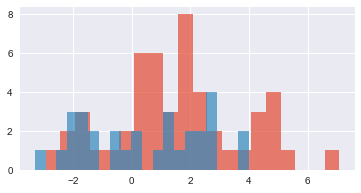

In [37]:
fig,ax=plt.subplots(1,figsize=(6,3))
ax.hist(MIR_HCC,alpha=0.7,bins=20)
ax.hist(MIR_Normal,alpha=0.7,bins=20)
#ax.hist(MIR_HBV_Normal,alpha=0.7,bins=20)

#####  boxplot fig4

In [38]:
def box_plot_3(styind,contextind,width,height,showdot,showbox,dotsize,fontsize,
               ylim,boxwidth,box_violin,compareheight1,compareheight2,compareheight3,compareheight4,
              compareheight5,compareheight6,palettesind,saturation):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])


    fig, ax = plt.subplots(figsize=(width,height))
    if showbox =='yes':
        if box_violin=='violin':
            sns.violinplot(ax=ax,x="sample", y="expression", data=wholetab3, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
        elif box_violin=='box':
            sns.boxplot(ax=ax,x="sample", y="expression", data=wholetab3, palette=palettes[palettesind],width=boxwidth,saturation=saturation)
    if showdot =='yes':
        sns.swarmplot(x="sample", y="expression", data=wholetab3, size=dotsize, edgecolor="black", linewidth=.9)
    ax.set_ylim(ylim)
    # statistical annotation
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = wholetab3['expression'].max() + compareheight1, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc1)+ '\n ns', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 0, 2
    y, h, col = wholetab3['expression'].max() + compareheight2, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc2)+ ' \n ns', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 3, 4 
    y, h, col = wholetab3['expression'].max() + compareheight3, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc3)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 3, 5
    y, h, col = wholetab3['expression'].max() + compareheight4, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc4)+ ' \n ****', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 6, 7
    y, h, col = wholetab3['expression'].max() + compareheight5, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc5)+ ' \n ns', ha='center', va='bottom', color=col,size=fontsize)
    x1, x2 = 6, 8
    y, h, col = wholetab3['expression'].max() + compareheight6, 0.5, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
    plt.text((x1+x2)*.5, y+h, 'FC ' +str('%0.4s'%fc6)+ ' \n ns', ha='center', va='bottom', color=col,size=fontsize)
interact(box_plot_3,styind=FloatSlider(min=0,max=3,step=1,value=2),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=8,max=20,step=1,value=16),
                 height= FloatSlider(min=4,max=10,step=1,value=6),
         boxwidth= FloatSlider(min=0.05,max=1,step=0.05,value=0.6),
         dotsize= FloatSlider(min=1,max=8,step=1,value=5),
         fontsize= FloatSlider(min=8,max=30,step=2,value=12),
         ylim=FloatRangeSlider(value=[-10, 25],min=-20,max=30.0,step=3),
            showdot=RadioButtons(options=['yes','no']),
        box_violin = Dropdown(options=['box','violin'],value='violin'),
         compareheight1=FloatSlider(min=3,max=10,step=1,value=3),
         compareheight2=FloatSlider(min=3,max=10,step=1,value=6),
         compareheight3=FloatSlider(min=3,max=10,step=1,value=3),
        compareheight4=FloatSlider(min=3,max=10,step=1,value=6),
        compareheight5=FloatSlider(min=3,max=10,step=1,value=3),
         showbox=RadioButtons(options=['yes','no']),
        compareheight6=FloatSlider(min=3,max=10,step=1,value=6),
        palettesind=IntSlider(min=0,max=len(palettes)-1,step=1,value=4),
        saturation=FloatSlider(min=0,max=1,step=0.1,value=0.8))

interactive(children=(FloatSlider(value=2.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=16.0, description=u'width', max=20.0, min=8.0, step=1.0), FloatSlider(value=6.0, description=u'height', max=10.0, min=4.0, step=1.0), RadioButtons(description=u'showdot', options=('yes', 'no'), value='yes'), RadioButtons(description=u'showbox', options=('yes', 'no'), value='yes'), FloatSlider(value=5.0, description=u'dotsize', max=8.0, min=1.0, step=1.0), FloatSlider(value=12.0, description=u'fontsize', max=30.0, min=8.0, step=2.0), FloatRangeSlider(value=(-10.0, 25.0), description=u'ylim', max=30.0, min=-20.0, step=3.0), FloatSlider(value=0.6, description=u'boxwidth', max=1.0, min=0.05, step=0.05), Dropdown(description=u'box_violin', index=1, options=('box', 'violin'), value='violin'), FloatSlider(value=3.0, description=u'compareheight1', max=10.0, min=3.0, step=1.0), FloatSlider(value=6.0, description=u'compareheight2', max=10.0, min=3.0, step=1.0), FloatSlider(value=3.0, description=u'compareheight3', max=10.0, min=3.0, step=1.0), FloatSlider(value=6.0, description=u'compareheight4', max=10.0, min=3.0, step=1.0), FloatSlider(value=3.0, description=u'compareheight5', max=10.0, min=3.0, step=1.0), FloatSlider(value=6.0, description=u'compareheight6', max=10.0, min=3.0, step=1.0), IntSlider(value=4, description=u'palettesind', max=12), FloatSlider(value=0.8, description=u'saturation', max=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.box_plot_3>

#####  rocplot fig4

In [39]:
aucspesenarr = np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))).reshape(1,-1),
               np.array(find_metrics_best(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_HBV_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_HBV_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_HBV_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_HBV_Normal)))).reshape(1,-1)
               ))
auc,spe,sen= {},{},{}
for i in range(6):
    auc[i],spe[i],sen[i] = aucspesenarr[i][0],aucspesenarr[i][1],aucspesenarr[i][2]
label1 = ['S -HBV','S +HBV','Alu -HBV','Alu +HBV','MIR -HBV','MIR +HBV']
label2 = ['AUC: ' + str('%0.4s'%auc[i]) +' ['+str('%0.4s'%spe[i])+' '+str('%0.4s'%sen[i])+']' for i in range(6)]

def rocplot3(styind,contextind,width,height,linewid,color,linewid2,color2,transparency,fontsize,showmetrics):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])
    fig, ax = plt.subplots(figsize=(width,height))
    if len(color) !=3:
        color = ['r','g','b','m','y','c']
    if showmetrics =='yes':
        labels = [label1[i] +'\n'+label2[i] for i in range(6)]
    else:
        labels = [label1[i] for i in range(6)]
    a,b,_ = roc_curve(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[0],label=labels[0])
    a,b,_ = roc_curve(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[1],label=labels[1])
    a,b,_ = roc_curve(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[2],label=labels[2])
    a,b,_ = roc_curve(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_HBV_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[3],label=labels[3])
    a,b,_ = roc_curve(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[4],label=labels[4])
    a,b,_ = roc_curve(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_HBV_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_HBV_Normal)))   
    ax.plot(a,b,linewidth=linewid,color=color[5],label=labels[5])
    
    ax.legend(prop={'size': fontsize})
    #ax.plot(b,a,linewidth=linewid,color=color,linestyle='dashed') #solid’ | ‘dashed’, ‘dashdot’, ‘dotted
    ax.plot([0,1],[0,1], linewidth=linewid2,alpha=transparency,color=color2,linestyle='--')
interact(rocplot3,styind=FloatSlider(min=0,max=3,step=1,value=3),
               contextind=FloatSlider(min=0,max=3,step=1,value=1),
                width =FloatSlider(min=6,max=16,step=1,value=8),
                 height= FloatSlider(min=6,max=16,step=1,value=8),
        linewid= FloatSlider(min=1,max=4,step=0.3,value=1.5),
        color=SelectMultiple(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'],value=('b', 'g', 'r','m')),
        linewid2= FloatSlider(min=1,max=4,step=0.3,value=1.5),
         fontsize= FloatSlider(min=6,max=20,step=1,value=10),
        transparency=FloatSlider(min=0,max=1,step=0.05,value=0.5),
        color2=Dropdown(options=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']),
        showmetrics=RadioButtons(options=['yes','no']))

interactive(children=(FloatSlider(value=3.0, description=u'styind', max=3.0, step=1.0), FloatSlider(value=1.0, description=u'contextind', max=3.0, step=1.0), FloatSlider(value=8.0, description=u'width', max=16.0, min=6.0, step=1.0), FloatSlider(value=8.0, description=u'height', max=16.0, min=6.0, step=1.0), FloatSlider(value=1.5, description=u'linewid', max=4.0, min=1.0, step=0.3), SelectMultiple(description=u'color', index=(0, 1, 2, 4), options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value=('b', 'g', 'r', 'm')), FloatSlider(value=1.5, description=u'linewid2', max=4.0, min=1.0, step=0.3), Dropdown(description=u'color2', options=('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'), value='b'), FloatSlider(value=0.5, description=u'transparency', max=1.0, step=0.05), FloatSlider(value=10.0, description=u'fontsize', max=20.0, min=6.0, step=1.0), RadioButtons(description=u'showmetrics', options=('yes', 'no'), value='yes'), Output()), _dom_classes=('widget-interact',))

<function __main__.rocplot3>

In [40]:
pd.DataFrame(np.concatenate((np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_Normal.shape[0]]))),np.concatenate((S_HCC,S_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([S_HCC.shape[0]]),np.zeros([S_HBV_Normal.shape[0]]))),np.concatenate((S_HCC,S_HBV_Normal)))).reshape(1,-1),
               np.array(find_metrics_best(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([Alu_HCC.shape[0]]),np.zeros([Alu_HBV_Normal.shape[0]]))),np.concatenate((Alu_HCC,Alu_HBV_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_Normal)))).reshape(1,-1),
                np.array(find_metrics_best(np.concatenate((np.ones([MIR_HCC.shape[0]]),np.zeros([MIR_HBV_Normal.shape[0]]))),np.concatenate((MIR_HCC,MIR_HBV_Normal)))).reshape(1,-1)
               )),columns=['AUC','Specificity','Sensitivity'],
             index=['S -HBV','S +HBV','Alu -HBV','Alu +HBV','MIR -HBV','MIR +HBV'])


,AUC,Specificity,Sensitivity
S -HBV,0.720000,0.85,0.566667
S +HBV,0.804200,0.83,0.740000
Alu -HBV,0.572333,0.79,0.400000
Alu +HBV,0.555800,0.88,0.220000
MIR -HBV,0.620333,0.74,0.500000
MIR +HBV,0.558800,0.72,0.420000


In [41]:
def test_data(data,i):
    print data
    print (i)
interact(test_data(np.arange(0,5)),
         i=FloatSlider(min=0,max=3,step=1,value=3))

TypeError: test_data() takes exactly 2 arguments (1 given)

In [ ]:
from functools import partial

def test_data(data,i):
    print ('this is data: '+str(data))
    print (i)


# Define the new partial function with df_pnl loaded.
test_data_partial = partial(test_data, data=np.arange(0,5))

interact(test_data_partial,
         i=FloatSlider(min=0,max=3,step=1,value=3))